In [72]:
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

In [15]:
base_dir = "/home/olivito/datasci/spark/clustertest/dimuonReduced_180123_153653/"
input_path_mll = base_dir + "mll_merged.parquet"
input_path_counts = base_dir + "count_merged.parquet"
df_mll = pq.ParquetDataset(input_path_mll).read().to_pandas()
df_counts = pq.ParquetDataset(input_path_counts).read().to_pandas().set_index('sampleID')

In [16]:
print len(df_mll)
df_mll.tail()

10618882


,mll,sampleID
10618877,92.303795,101
10618878,82.218849,101
10618879,76.960869,101
10618880,168.510880,101
10618881,85.172569,101


In [18]:
print df_counts['count'][101]

87683348


In [26]:
lumi = 11.6 # in fb-1, for 2012B+C
df_counts['weight'] = lumi * 1000. * df_counts['xsec'] / df_counts['count']
# reset the data samples to have weight = 1.  not used anyway
df_counts['weight'][100] = 1
df_counts['weight'][101] = 1
df_counts

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,name,xsec,count,weight
sampleID,,,,
0,DYJetsToLL,3531.150000,30443822,1.345473
1,TTJets_SemiLeptMGDecays,106.150000,24949110,0.049354
2,TTJets_FullLeptMGDecays,26.800000,12116717,0.025657
3,T_tW-channel,11.100000,497658,0.258732
4,Tbar_tW-channel,11.100000,493460,0.260933
5,WWJetsTo2L2Nu,5.812300,1933120,0.034878
6,WZJetsTo2L2Q,2.206000,3215990,0.007957
7,WZJetsTo3LNu,1.057500,2133868,0.005749
8,ZZTo4mu,0.019656,1467583,0.000155


In [30]:
def get_weight(id):
    return df_counts['weight'][id]

# this is very slow... there's probably a much faster way to do this
df_mll['weight'] = df_mll['sampleID'].apply(get_weight)

In [32]:
df_mll.head()

,mll,sampleID,weight
0,92.448212,0,1.345473
1,96.570663,0,1.345473
2,90.192520,0,1.345473
3,90.843185,0,1.345473
4,91.686333,0,1.345473


In [73]:
# map of sampleID numbers to samples for the final plot

samples_dict = OrderedDict()
samples_dict['W+jets'] = [11,12,13]
samples_dict['WW'] = [5]
samples_dict['ZZ'] = [8,9,10]
samples_dict['WZ'] = [6,7]
samples_dict['single top'] = [3,4]
samples_dict['ttbar'] = [1,2]
samples_dict['Drell-Yan'] = [0]

samples_dfs = OrderedDict()
for sample,IDs in samples_dict.items():
    samples_dfs[sample] = df_mll.loc[df_mll['sampleID'].isin(IDs)]
    
# treat data separately
df_data = df_mll.loc[df_mll['sampleID'].isin([100,101])]

In [74]:
color_dict = OrderedDict()
color_dict['W+jets'] = 'gray'
color_dict['WW'] = 'cyan'
color_dict['ZZ'] = 'magenta'
color_dict['WZ'] = 'red'
color_dict['single top'] = 'yellow'
color_dict['ttbar'] = 'green'
color_dict['Drell-Yan'] = 'blue'

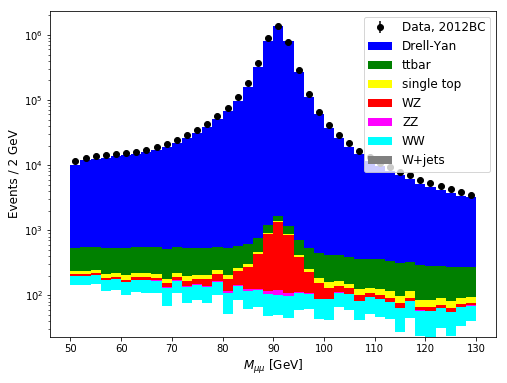

In [80]:
fig = plt.figure(figsize=(8,6))

# set up binning.  get also bin centers, to use for data points
bin_size = 2
xmin = 50
xmax = 131 # should make this slightly larger than the desired end point of the plot
binning = np.arange(xmin,xmax,bin_size)
binning_centers = np.arange(xmin + bin_size/2.,xmax,bin_size)

# for MC, can plot all together as a stacked histogram
plt.hist([df['mll'] for df in samples_dfs.values()],
         weights=[df['weight'] for df in samples_dfs.values()],
         label=samples_dfs.keys(),
         color=color_dict.values(),
         bins=binning, histtype='bar', stacked=True
        )

# for data, get the bin counts and plot with error bars
hist_data,_ = np.histogram(df_data['mll'],binning)
errors_data = np.sqrt(hist_data)
plt.errorbar(binning_centers, hist_data, errors_data,
             linestyle='none', marker='o', color='black', label='Data, 2012BC'
            )

# add axis labels and legend
plt.xlabel('$M_{\mu\mu}$ [GeV]',fontsize='large')
plt.ylabel('Events / '+str(bin_size)+' GeV',fontsize='large')
ax = plt.gca() # "get current axis"
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), fontsize='large')  # reverse to keep order consistent

#fig.savefig('mll_multisample_lin.png')

plt.yscale('log')
fig.savefig('mll_multisample_log.png')

plt.show()

Not sure what is going on with the white fill color for W+jets in the stacked plot..